# Prediction with pre-trained CNNs
This notebook contains all the code you need to use a pre-trained OpenSoundscape convolutional neural network model (CNN) to make predictions on your own data. Before attempting this tutorial, install OpenSoundscape by following the instructions on the OpenSoundscape website, [opensoundscape.org](http://opensoundscape.org/). More detailed tutorials about data preprocessing, training CNNs, and customizing prediction methods can also be found on this site.

Note that prediction no longer requires you to split your files into clips ahead of time - you can simply create a list of audio files of arbitrary length. Prediction scores will be generated on windows of a fixed length, eg 5 seconds, for the duration of each audio file. 

## Load required packages

The `cnn` module provides a function `load_model` to load saved opensoundscape models

In [1]:
from opensoundscape.torch.models.cnn import load_model, load_outdated_model
import opensoundscape

load some additional packages and perform some setup for the Jupyter notebook.

In [2]:
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [3]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

create and save a model object to use for demonstration in this notebook:

In [4]:
from opensoundscape.torch.models.cnn import PytorchModel
PytorchModel('resnet18',[0,1,2]).save('./temp.model')

created PytorchModel model object with 3 classes


## Load a saved model
For this example, let's download a pre-trained model from the Kitzes Lab box to use as an example. This 2-class model is not actually good at recognizing any particular species, but it's useful for illustrating how prediction works. 

In [5]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/s9lydizgspwsimo4p5l5j4nf9yeg319k.model', 
                '-L', '-o', 'example.model'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      6      0 --:--:--  0:00:01 --:--:--     0
100 85.4M  100 85.4M    0     0  4049k      0  0:00:21  0:00:21 --:--:-- 5221k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/s9lydizgspwsimo4p5l5j4nf9yeg319k.model', '-L', '-o', 'example.model'], returncode=0)

load the model object using the `load_model` function

In [6]:
model = load_model('./example.model')

### Choose audio files for prediction

Create a list of audio files to predict on. They can be of any length. Consider using `glob` to find many files at once.

For this example, let's download a 1-minute audio clip from the Kitzes Lab box to use as an example.

In [7]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav', 
                '-L', '-o', '1min_audio.wav'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      5      0 --:--:--  0:00:01 --:--:--     5
100 3750k  100 3750k    0     0  1220k      0  0:00:03  0:00:03 --:--:-- 3357k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav', '-L', '-o', '1min_audio.wav'], returncode=0)

In [8]:
from glob import glob 
audio_files = glob('./*.wav') #match all .wav files in the current directory
audio_files

['./1min_audio.wav']

### Prepare a dataframe and dataset for prediction
The prediction dataframe will have the names of each file and the start and end time of each window that we want to generate predictions for. OpenSoundscape provides a helper function to create this dataframe in the case where we want to predict on fixed-length windows with a fixed overlap between consecutive windows. Note that we need to know the duration of clips that the model expects, eg 5 second clips for the model we downloaded above.

In [9]:
from opensoundscape.helpers import make_clip_df
clip_df = make_clip_df(files=audio_files,clip_duration=5.0)
clip_df.head()

,start_time,end_time
file,,
./1min_audio.wav,0.0,5.0
./1min_audio.wav,5.0,10.0
./1min_audio.wav,10.0,15.0
./1min_audio.wav,15.0,20.0
./1min_audio.wav,20.0,25.0


note that we might need to change the preprocessing parameters of our Preprocessor object to match the model's preprocessing used during training (e.g. spectrogram parameters or bandpassing)

In [10]:
from opensoundscape.preprocess.preprocessors import ClipLoadingSpectrogramPreprocessor
prediction_dataset = ClipLoadingSpectrogramPreprocessor(clip_df)

we can check on the parameters used during trainig by accessing model.train_dataset. For instance, check the bandpassing behavior of the training dataset:

(Note that an empty params dictionary indicates that default values were used)

In [11]:
model.train_dataset.actions.bandpass.params

{'min_f': 0, 'max_f': 11025, 'out_of_bounds_ok': False}

## generate predictions with the model
The model returns a dataframe with a MultiIndex of file, start_time, and end_time. There is one column for each class. 

In [12]:
scores, _, _ = model.predict(prediction_dataset)
scores.head()

(12, 2)


absent   present
file             start_time end_time                    
./1min_audio.wav 0.0        5.0       0.277278 -0.293570
                 5.0        10.0      0.359079 -0.363364
                 10.0       15.0     -1.124166  1.038807
                 15.0       20.0      0.350859 -0.332194
                 20.0       25.0     -3.864331  3.613130

## Using models from older OpenSoundscape versions
Models trained and saved with OpenSoundscape versions prior to 0.6.1 need to be loaded in a different way, and require that you know the architecture of the saved model. 

For example, one set of our publicly availably [binary models for 500 species](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) was created with an older version of OpenSoundscape. These models require a little bit of manipulation to load into OpenSoundscape 0.5.x and onward. From the model notes page, we know that these models were trained with a resnet18 architecture. We can load them into a PytorchModel class. 

First, let's download one of these models (it's stored in a .tar format) and save it to the same directory as this notebook in a file called `opso_04_model_acanthis-flammea.tar`

In [13]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', 
                '-L', '-o', 'opso_04_model_acanthis-flammea.tar'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      6      0 --:--:--  0:00:01 --:--:--     6
100 42.9M  100 42.9M    0     0  2720k      0  0:00:16  0:00:16 --:--:-- 5099k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', '-L', '-o', 'opso_04_model_acanthis-flammea.tar'], returncode=0)

In [14]:
from opensoundscape.torch.models.cnn import load_outdated_model
from opensoundscape.torch.architectures import cnn_architectures

the load_outdated_model function will expect us to specify the model class (we'll use PytorchModel) and architecture constructor (we'll use cnn_architectures.resnet18). In this case, we also want to specify that the model should be single-tartet (models are multi-target by default)

In [15]:
model = load_outdated_model('./opso_04_model_acanthis-flammea.tar',model_class = PytorchModel,architecture_constructor=cnn_architectures.resnet18)
model.single_target = True

created PytorchModel model object with 2 classes
<All keys matched successfully>


The model is now fully compatible with OpenSoundscape, and can be used as above. For example:

In [16]:
scores, _, _ = model.predict(prediction_dataset)
scores.head()

(12, 2)


acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      5.777371   
                 5.0        10.0                     4.891728   
                 10.0       15.0                     5.632080   
                 15.0       20.0                     4.748437   
                 20.0       25.0                     4.424040   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      -5.517636  
                 5.0        10.0                     -4.772002  
                 10.0       15.0                     -5.395757  
                 15.0       20.0                     -5.166635  
                 20.0       25.0                     -5.115609

## Options for prediction

The code above returns the raw predictions of the model without any post-processing (such as a softmax layer or a sigmoid layer). 

For details on how to use the `predict()` function for post-processing of predictions and to generate binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. But, as a quick example, let's add a softmax layer to make the prediction scores for both classes sum to 1. We can also use the `binary_preds` argument to generate 0/1 predictions for each sample and class. For presence/absence models, use the option `binary_preds='single_target'`. For multi-class models, think about whether each clip should be labeled with only one class (single target) or whether each clip could contain multiple classes (`binary_preds='multi_target'`)

In [17]:
scores, binary_predictions, _ = model.predict(
    prediction_dataset,
    activation_layer='softmax',
    binary_preds='single_target'
)

(12, 2)


As before, the `scores` are continuous variables, but now have been softmaxed:

In [18]:
scores.head()

acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      0.999988   
                 5.0        10.0                     0.999936   
                 10.0       15.0                     0.999984   
                 15.0       20.0                     0.999951   
                 20.0       25.0                     0.999928   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                       0.000012  
                 5.0        10.0                      0.000064  
                 10.0       15.0                      0.000016  
                 15.0       20.0                      0.000049  
                 20.0       25.0                      0.000072

We also have an additional output, the binary 0/1 ("absent" vs "present") predictions generated by the model:

In [19]:
binary_predictions.head()

acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                           1.0   
                 5.0        10.0                          1.0   
                 10.0       15.0                          1.0   
                 15.0       20.0                          1.0   
                 20.0       25.0                          1.0   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                            0.0  
                 5.0        10.0                           0.0  
                 10.0       15.0                           0.0  
                 15.0       20.0                           0.0  
                 20.0       25.0                           0.0

It is sometimes helpful to look at a histogram of the scores:

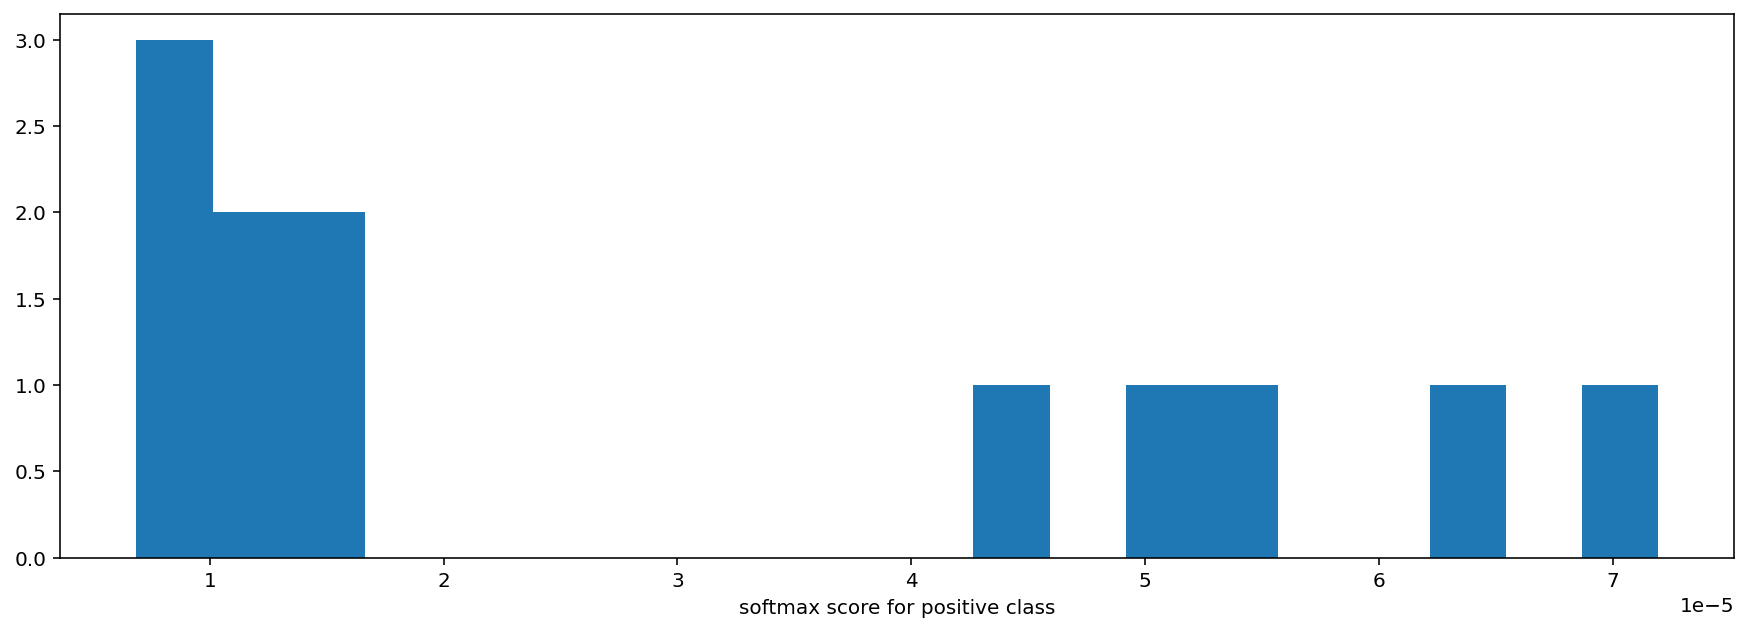

In [20]:
_ = plt.hist(scores['acanthis-flammea-present'],bins=20)
_ = plt.xlabel('softmax score for positive class')

## Deprecated: Using LongAudioPreprocessor to predict on (un-split) audio files

It's also possible to run predictions on long audio files by loading entire files and letting OpenSoundscape split them while predicting. This is deprecated in favor of the approach shown above and has high memory (RAM) requirements. In this case, OpenSoundscape will internally split the audio into short segments during prediction. The input dataframe in this case is simply a dataframe with file paths. The model.split_and_predict() method expects the user to provide the audio clip length.  

Let's look at an example. We'll use the 1 minute audio file contained within OpenSoundscape's test folder as a "long" audio file. In practice, you can split files that are multiple hours long - the limiting factor is your computer's memory ("RAM"), which must be able to hold the entire audio file. 

In [21]:
import opensoundscape
from opensoundscape.preprocess.preprocessors import LongAudioPreprocessor

#get audio path from opensoundscape's tests folder
long_audio_prediction_df = pd.DataFrame(index=audio_files)
img_shape = [224,224]

#the audio will be split during prediction. choose the clip length and overlap of sequential clips (0 for no overlap)
clip_length = 5.0
clip_overlap = 0.0
long_audio_prediction_ds = LongAudioPreprocessor(
    long_audio_prediction_df,
    audio_length=clip_length, 
    clip_overlap=clip_overlap, 
    out_shape=img_shape, 
)


/Users/SML161/opt/miniconda3/envs/opso/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated class LongAudioPreprocessor. (Use ClipLoadingSpectrogramPreprocessorfor similar functionality with lower memory requirements.) -- Deprecated since version 0.6.1.
  from ipykernel import kernelapp as app


in addition to the scores (and potentially, predictions) the function returns a list of "unsafe" samples that caused errors during preprocessing. 

In [22]:
score_df, pred_df, unsafe_samples = model.split_and_predict(
    long_audio_prediction_ds,
    file_batch_size=1,
    num_workers=0,
    activation_layer=None,
    binary_preds='single_target',
    threshold=0.5,
    clip_batch_size=4,
    error_log=None,
)
score_df.head()

/Users/SML161/opt/miniconda3/envs/opso/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated method split_and_predict. (Use ClipLoadingSpectrogramPreprocessorwith model.predict() for similar functionality but lower memory requirements.) -- Deprecated since version 0.6.1.
  if __name__ == '__main__':


acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      5.777371   
                 5.0        10.0                     4.891728   
                 10.0       15.0                     5.632079   
                 15.0       20.0                     4.748437   
                 20.0       25.0                     4.424040   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      -5.517637  
                 5.0        10.0                     -4.772002  
                 10.0       15.0                     -5.395757  
                 15.0       20.0                     -5.166635  
                 20.0       25.0                     -5.115609

### Clean up: delete model objects

In [24]:
from glob import glob
from pathlib import Path
for p in Path('.').glob('*.model'):
    p.unlink()
for p in Path('.').glob('*.tar'):
    p.unlink()
Path('1min_audio.wav').unlink()